In [2]:
import mlflow
import matplotlib.pyplot as plt
import mlflow.xgboost

from xgboost import XGBClassifier
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import datasets

import tempfile
import pandas as pd
import numpy as np
import typing as t
import os

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
mlflow.set_tracking_uri('../mlruns')
mlflow.set_experiment('wine-gridsearchcv')

<Experiment: artifact_location='file:///Users/ciri/Desktop/sofia/xp/wine-ml-api/mlruns/869593139509224446', creation_time=1727720598241, experiment_id='869593139509224446', last_update_time=1727720598241, lifecycle_stage='active', name='wine-gridsearchcv', tags={}>

## Get Data

In [6]:
dataset = datasets.load_wine()

dataset_df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
dataset_df['target'] = dataset.target
dataset_df['label'] = [dataset.target_names.tolist()[t] for t in dataset.target]

## Split Data

In [7]:
def _get_X_y(df: pd.DataFrame) -> t.Tuple:
    X = df.iloc[:, :-2]
    y = df["target"].tolist()
    
    return X, y

In [8]:
random_state=12
test_size = 0.2

In [9]:
train_set, test_set = train_test_split(
    dataset_df,
    test_size=test_size,
    random_state=random_state,
    stratify=dataset_df['target']
)

In [10]:
X_train, y_train = _get_X_y(train_set)
X_test, y_test = _get_X_y(test_set)

## Train Model

In [11]:
def _create_confusion_matrix(y_test, y_pred, labels, temp_dir):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Previsão',fontsize=12)
    plt.xlabel('Verdadeiro',fontsize=12)
    plt.title('Matriz de Confusão',fontsize=16)

    output_path = os.path.join(temp_dir, 'confusion_matrix.png')
    plt.savefig(output_path)
    
    return output_path

In [12]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'objective': ['multi:softmax', 'multi:softprob']
}

model_name = "wine_classification_xgboost_gridsearch"

f1_scorer = make_scorer(f1_score, average='weighted')

In [13]:
xgb_model = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring=f1_scorer, cv=5)

/Users/ciri/micromamba/envs/xp-wine-kedro-311/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [20:47:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2024/09/30 20:47:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'wine_classification_xgboost_gridsearch' already exists. Creating a new version of this model...
Created version '10' of model 'wine_classification_xgboost_gridsearch'.


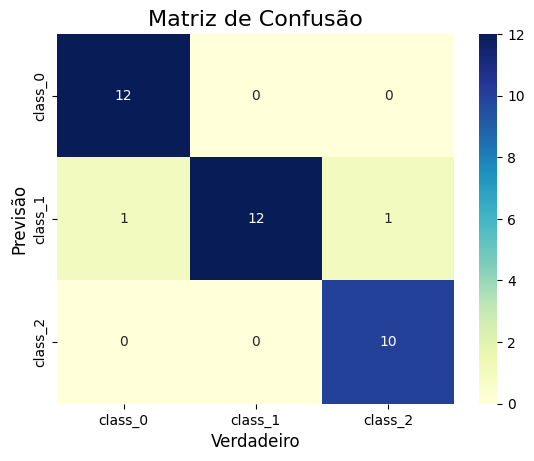

In [14]:
with mlflow.start_run() as run:
    grid_search.fit(X_train, y_train)

    mlflow.xgboost.log_model(grid_search.best_estimator_, "model")

    for param_name, param_value in grid_search.best_params_.items():
        mlflow.log_param(param_name, param_value)

    best_score = grid_search.best_score_
    mlflow.log_metric("best_f1_score", best_score)
    mlflow.log_param("model_type", "xgboost")

    y_pred = grid_search.best_estimator_.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision_weighted = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_weighted", precision_weighted)
    mlflow.log_metric("recall_weighted", recall_weighted)
    mlflow.log_metric("f1_weighted", f1_weighted)

    with tempfile.TemporaryDirectory() as temp_dir:
        train_file_path = os.path.join(temp_dir, "train.parquet")
        test_file_path = os.path.join(temp_dir, "test.parquet")

        train_set.to_parquet(train_file_path, index=False)
        test_set.to_parquet(test_file_path, index=False)

        mlflow.log_artifact(train_file_path, artifact_path="datasets")
        mlflow.log_artifact(test_file_path, artifact_path="datasets")
  
        cm_file_name = _create_confusion_matrix(y_test, y_pred, dataset.target_names, temp_dir)
        mlflow.log_artifact(cm_file_name, artifact_path="stats")

    mlflow.register_model("runs:/{}/model".format(run.info.run_id), model_name)